# (1) Pure Linear Projection

I'm not sure I understand the issue. Right now all we really want is to see a **scatter plot of path projection predictions vs. human collider placements**, as a baseline to compare a more sophisticated model that uses intuitive physics.

## Load Dataset

In [4]:
import pandas as pd
import statsmodels.api as sm
import os
import json
import ast
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.linear_model import LinearRegression
from scipy.stats import binned_statistic_2d
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib.colorbar import ColorbarBase
from matplotlib.cm import hsv
from shapely.geometry import Point, LineString
import pybrms
from similaritymeasures import frechet_dist
from scipy.stats import pearsonr
from scipy.stats import norm
from scipy.stats import multivariate_normal
import pickle
import subprocess
from scipy.optimize import minimize, Bounds

canvasWidth = 1000 

In [7]:
def string2List(dataString):
    dataList = ast.literal_eval(dataString)
    return dataList

In [5]:
def getBIC(k, sampleSize, sumLogLike):
    result = k*np.log(sampleSize) - 2*sumLogLike
    return result

## Add fd_metric to the dataframe

In [ ]:
segmented_line = [((250, 150), (250, 450)), ((250, 450), (750, 450)), ((750, 450), (750, 150))]
top_y = 150
bottom_y = 450
left_x = 150
right_x = 750
ball_radius = 30

In [ ]:
# select all points that are outside of the screen
# return list1, list2
# list1: list of points that form the path before the ball enters the screen (when ball_y <= top_y + ball_radius)
# list2: list of points that form the path before the ball exits the screen (when ball_y >= bottom_y - ball_radius or ball_x <= left_x + ball_radius or ball_x >= right_x - ball_radius)
def pickPointsOutScreen(path, top_y, bottom_y, left_x, right_x, ball_radius, keepSpeed = False):
    list1 = []
    list2 = []
    if len(path[0])==3:
        for ball_x,ball_y,speed in path:
            if ball_y <= top_y + ball_radius:
                if keepSpeed:
                    list1.append((ball_x,ball_y,speed))
                else:
                    list1.append((ball_x,ball_y))
            if (ball_y >= bottom_y - ball_radius) or (ball_x <= left_x + ball_radius) or (ball_x >= right_x - ball_radius):
                if keepSpeed:
                    list2.append((ball_x,ball_y,speed))
                else:
                    list2.append((ball_x,ball_y))
    else: 
        for ball_x,ball_y in path:
            if ball_y <= top_y + ball_radius:
                list1.append((ball_x,ball_y))
            if (ball_y >= bottom_y - ball_radius) or (ball_x <= left_x + ball_radius) or (ball_x >= right_x - ball_radius):
                list2.append((ball_x,ball_y))
    return list1, list2

# calculate Fréchet distance between list1_participant and list1_groundTruth (fd1) and list2_participant and list2_groundTruth (fd2)
# return fd1, fd2
def evaluateResponseByFD(rowData):
    simulatedPath = rowData['simulated_path']
    exactPath = rowData['exact_path_single']
    l1_p, l2_p = pickPointsOutScreen(simulatedPath, top_y, bottom_y, left_x, right_x, ball_radius)
    l1_g, l2_g = pickPointsOutScreen(exactPath, top_y, bottom_y, left_x, right_x, ball_radius)
    fd1 = frechet_dist(l1_p, l1_g)
    fd2 = frechet_dist(l2_p, l2_g)
    return fd1, fd2

## Load Full Data Stored from Previous Analysis

In [8]:
allData = pd.read_csv('df_all_with_single_ground_trajectory_simulation_fd_pilot_v1.csv')
allData['exact_path_single'] = allData['exact_path_single'].apply(string2List)
allData['simulated_path'] = allData['simulated_path'].apply(string2List)
allData['fd_combined'] = allData['fd1_enter'] + allData['fd2_exit']

In [9]:
allData

,participant_ID,currentTrial,subject_id,study_id,session_id,trial_index_x,trial_name,flipped,ball_X,triangle_final_x,...,obstacle_groundTruth_x_final,obstacle_initial_x_final,triangle_final_x_flipback,exact_path_single,trial_index_y,trail,simulated_path,fd1_enter,fd2_exit,fd_combined
0,60fdb8ef572006d42ee49b20_result,1.0,60fdb8ef572006d42ee49b20,6509bb9f610e9a3075ec3f2e,650e0cef2fa669e369cb8f10,29,fallScene,False,500.0,497.000000,...,479.921143,500.0,497.000000,"[(745.1542440234385, 598.1346571356694, 15.980...",1,"[{""position"":{""x"":674.650608649849,""y"":597.363...","[(674.650608649849, 597.3636069522425, 14.0117...",0.000000,70.507851,70.507851
1,60fdb8ef572006d42ee49b20_result,2.0,60fdb8ef572006d42ee49b20,6509bb9f610e9a3075ec3f2e,650e0cef2fa669e369cb8f10,31,fallScene,False,322.3,360.000002,...,379.371143,375.0,360.000002,"[(141.56393523822751, 598.0243719293794, 16.69...",2,"[{""position"":{""x"":140.57296769917704,""y"":597.4...","[(140.57296769917704, 597.4435821545951, 16.76...",0.000000,6.758374,6.758374
2,60fdb8ef572006d42ee49b20_result,3.0,60fdb8ef572006d42ee49b20,6509bb9f610e9a3075ec3f2e,650e0cef2fa669e369cb8f10,33,fallScene,False,322.3,378.010000,...,379.371143,500.0,378.010000,"[(141.56393523822751, 598.0243719293794, 16.69...",3,"[{""position"":{""x"":139.9016943947788,""y"":597.05...","[(139.9016943947788, 597.0572603873229, 16.756...",0.000000,6.850577,6.850577
3,60fdb8ef572006d42ee49b20_result,4.0,60fdb8ef572006d42ee49b20,6509bb9f610e9a3075ec3f2e,650e0cef2fa669e369cb8f10,35,fallScene,False,500.0,489.010000,...,453.671143,500.0,489.010000,"[(680.1946407681826, 598.313466274789, 16.9041...",4,"[{""position"":{""x"":714.4381220918268,""y"":597.22...","[(714.4381220918268, 597.2267031235519, 15.693...",36.442890,45.605912,82.048801
4,60fdb8ef572006d42ee49b20_result,5.0,60fdb8ef572006d42ee49b20,6509bb9f610e9a3075ec3f2e,650e0cef2fa669e369cb8f10,37,fallScene,True,322.3,650.999930,...,643.578857,375.0,349.000070,"[(157.40552600496406, 595.8290296388146, 16.38...",5,"[{""position"":{""x"":146.4479708621239,""y"":595.11...","[(146.4479708621239, 595.1109729551606, 16.951...",14.085562,48.675900,62.761462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,5ec75df0d799ae1c11a8115c_result,68.0,5ec75df0d799ae1c11a8115c,6509bb9f610e9a3075ec3f2e,650e0f52a698077237c86766,155,fallScene,True,500.0,527.000000,...,546.328857,500.0,473.000000,"[(680.1946407681826, 598.313466274789, 16.9041...",68,"[{""position"":{""x"":681.6196489718302,""y"":597.49...","[(681.6196489718302, 597.4937698582781, 16.861...",0.000000,1.643944,1.643944
1436,5ec75df0d799ae1c11a8115c_result,69.0,5ec75df0d799ae1c11a8115c,6509bb9f610e9a3075ec3f2e,650e0f52a698077237c86766,157,fallScene,True,500.0,537.994224,...,546.328857,500.0,462.005776,"[(680.1946407681826, 598.313466274789, 16.9041...",69,"[{""position"":{""x"":680.3989063568873,""y"":598.22...","[(680.3989063568873, 598.221503029535, 16.6792...",0.000000,15.021575,15.021575
1437,5ec75df0d799ae1c11a8115c_result,70.0,5ec75df0d799ae1c11a8115c,6509bb9f610e9a3075ec3f2e,650e0f52a698077237c86766,159,fallScene,True,500.0,474.000007,...,446.528857,375.0,525.999993,"[(324.54735090761613, 595.3902860340756, 16.53...",70,"[{""position"":{""x"":322.05824591613003,""y"":599.6...","[(322.05824591613003, 599.6493468921726, 16.60...",0.000000,4.933076,4.933076
1438,5ec75df0d799ae1c11a8115c_result,71.0,5ec75df0d799ae1c11a8115c,6509bb9f610e9a3075ec3f2e,650e0f52a698077237c86766,161,fallScene,True,604.4,455.010000,...,403.128857,625.0,544.990000,"[(870.6645057101811, 598.9245168418013, 13.541...",71,"[{""position"":{""x"":777.2171263786798,""y"":596.91...","[(777.2171263786798, 596.9156229743667, 16.531...",0.000000,93.468970,93.468970


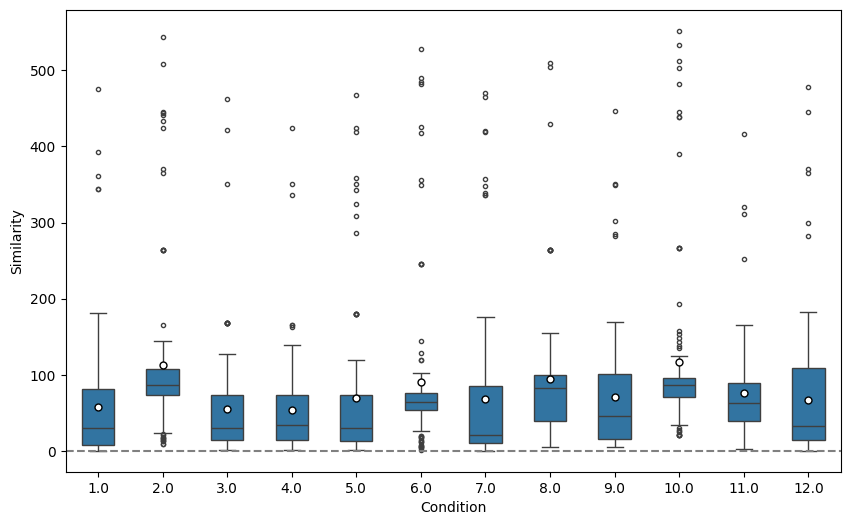

In [10]:
import seaborn as sns

# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='stimulus_idx', y='fd_combined', data=allData, width = 0.5, flierprops={"marker": "o", "markersize": 3},showmeans=True,  
            meanprops={'marker':'o',
                       'markerfacecolor':'white', 
                       'markeredgecolor':'black',
                       'markersize':'5'})

# Add a horizontal line at y=0
plt.axhline(y=0, color='gray', linestyle='--')

# Adding labels and title
plt.xlabel('Condition')
plt.ylabel('Similarity')
# plt.title('Distribution of Fréchet Distances Across Conditions')

# Show the plot
# plt.savefig('fd_12_conditions.pdf')
plt.show()

## Get Linear Projection Predictions

In [ ]:
segmented_line = [((250, 150), (250, 450)), ((250, 450), (750, 450)), ((750, 450), (750, 150))]

# Create a function that find the two consecutive coordinates of the ball when it is about to fall outside of the screen
def distance_to_segment(point, segment):
    """Calculate the distance from a point to a line segment."""
    return Point(point).distance(LineString(segment))

def closest_points_to_line(points, segmented_line = segmented_line):
    """Find two points that are nearest to the segmented line and are also near each other."""
    # Calculate distances from all points to the segmented line
    distances = [min(distance_to_segment(point, segment) for segment in segmented_line) for point in points]
    
    # Sort points based on their distance to the segmented line
    sorted_points = sorted(points, key=lambda p: min(distance_to_segment(p, segment) for segment in segmented_line))
    
    for point in sorted_points:
        # Sort other points based on their distance to the current point
        other_points = sorted(points, key=lambda p: np.linalg.norm(np.array(point) - np.array(p)))
        for near_point in other_points[1:3]:  # considering the 2 nearest points
            if abs(distances[points.index(point)] - distances[points.index(near_point)]) < 5:
                return point, near_point
    return None

# Function to get the first two elements of each tuple
def take_first_two(lst):
    return [(a, b) for a, b, _ in lst]

In [ ]:
# create the no speed path col
allData['exact_path_no_speed'] = allData['exact_path_single'].apply(take_first_two)

# create the vertical line col
allData['projected_line_0'] = allData['ball_X']

# create the tangential line col
allData['projected_line_1'] = allData['exact_path_no_speed'].apply(closest_points_to_line)

### check by visualizing

In [ ]:
def drawProjectedPath(condition, merged_trajectory, ax, zorder):
    # Given data
    subset = merged_trajectory[merged_trajectory['stimulus_idx']==condition]
#     print(subset['projected_line_0'])
    x_vertical = subset['projected_line_0'].iloc[0]
    point1 = subset['projected_line_1'].iloc[0][0]
    point2 = subset['projected_line_1'].iloc[0][1]
    
    # Calculate slope
    if (point2[0] - point1[0]) == 0:
        slope = float('inf')
    else:
        slope = (point2[1] - point1[1]) / (point2[0] - point1[0])
        
        
    # Calculate extended points based on the slope
    x_extended_1 = 100  # at the far left of the plot
    y_extended_1 = point1[1] + slope * (x_extended_1 - point1[0])

    x_extended_2 = 900  # at the far right of the plot
    y_extended_2 = point1[1] + slope * (x_extended_2 - point1[0])
    
    # Create the two line segments
    vertical_line = LineString([(x_vertical, -200), (x_vertical, 600)])  # assuming a large y range for the vertical line
    extended_line = LineString([(x_extended_1, y_extended_1), (x_extended_2, y_extended_2)])
    
    # Calculate intersection
    intersection = vertical_line.intersection(extended_line)
    print(f'stimulus:{condition}')
    print(intersection)

    # Plotting
    if intersection and 100 <= intersection.x <= 900 and 60 <= intersection.y <= 540:
        ax.plot([x_vertical, x_vertical], [0, intersection.y], label="Vertical Line", linestyle='--', color='black', zorder = zorder) 
        if intersection.y <= y_extended_1:
            ax.plot([x_extended_1, intersection.x], [y_extended_1, intersection.y], label="Extended Line", linestyle='--', color='black', zorder = zorder)
        else:
            ax.plot([intersection.x, x_extended_2], [intersection.y, y_extended_2], label="Extended Line", linestyle='--', color='black', zorder = zorder)
        ax.scatter(*intersection.xy, color='yellow', label="Intersection", s = 100, zorder = 20)
    else:
        ax.plot([x_vertical, x_vertical], [0, 600], label="Vertical Line", linestyle='--', color='black', zorder = zorder)  # using a large y range for visualization
        ax.plot([x_extended_1, x_extended_2], [y_extended_1, y_extended_2], label="Extended Line", linestyle='--', color='black', zorder = zorder)
        ax.scatter(*intersection.xy, color='yellow', label="Intersection", s = 100, zorder = 20)
    return intersection

def drawTrueTrajectory(condition, df, ax, zorder):
    subset = df[df['stimulus_idx'] == condition]
    trails = subset['exact_path_single']
    data_list = subset['exact_path_single'].iloc[0]
    x_coords = [item[0] for item in data_list]
    y_coords = [item[1] for item in data_list]
    ax.scatter(x_coords, y_coords, c='cyan', s=4, zorder = zorder)
    
def drawSimulatedTrajectory(condition, trajectoryName, df, ax, zorder):
    subset = df[df['stimulus_idx'] == condition]
    trails = subset[trajectoryName]
    data_list = subset[trajectoryName].iloc[0]
    x_coords = [item[0] for item in data_list]
    y_coords = [item[1] for item in data_list]
    ax.scatter(x_coords, y_coords, c='red', s=4, zorder = zorder)

In [ ]:
df_all = allData

In [ ]:
intersections = {}
conditions = np.sort(df_all['obstacle_idx'].unique())

# Define a color map for your conditions
color_map = {1: 'red', 2: 'red', 3: '#757575', 4: '#757575', 5: '#0088DE', 6: '#0088DE'}

# Reshape positions into a 3x4 array and flatten by column
positions = np.sort(df_all['stimulus_idx'].unique())
positions = positions.reshape((3, 4)).T.flatten()

fig, axs = plt.subplots(4, 3, figsize=(28, 24)) # Creates a 4x3 grid of Axes objects

# Empty lists to hold all handles and labels
handles, labels = [], []

for index, position in enumerate(positions):
    ax = axs.flatten()[index]  # Select the current Axes object

    # Draw triangle and rectangle
    x_coord = df_all.loc[df_all['stimulus_idx'] == position, 'obstacle_groundTruth_x'].values[0]
    y_coord = df_all.loc[df_all['stimulus_idx'] == position, 'obstacle_groundTruth_y'].values[0]
    x_coord_ball = df_all.loc[df_all['stimulus_idx'] == position, 'ball_X'].values[0]
    y_coord_ball = 100
    print(x_coord, y_coord)
    ball = patches.Circle((x_coord_ball, y_coord_ball), radius = 30, color = '#ececd1')
    triangle = patches.RegularPolygon((x_coord,y_coord), orientation=np.pi, numVertices=3, radius=45, color='#5fa55a', fill=True)
    rect = patches.Rectangle((250,150),500,300,linewidth=1, edgecolor='lightgray',facecolor='lightgray')
    ax.add_patch(ball)
    ax.add_patch(rect)
    ax.add_patch(triangle)
    
    for i, condition in enumerate(conditions):
        subset = df_all[(df_all['stimulus_idx'] == position) & (df_all['obstacle_idx'] == condition)]
        ax.scatter(subset["triangle_final_x_flipback"], subset["triangle_final_y"], s=20, color=color_map[i+1], alpha = 0.6)
        
        # Plot initial positions
        initial_x = subset['obstacle_initial_x'].unique()
        initial_y = subset['obstacle_initial_y'].unique()
        ax.scatter(initial_x, initial_y, marker='x', color='white',linewidth=5, s=130, zorder=10)  
        scatter = ax.scatter(initial_x, initial_y, marker='x', color=color_map[i+1],linewidth=3, s=100, zorder=10)  

        # Add handles and labels to lists
        if len(handles) < len(conditions):
            handles.append(scatter)
            labels.append(f'Initial position: {int(condition)}')
    
    # plot the true trajectory
    drawTrueTrajectory(position, df_all, ax, 7)
    
    # plot the simulated trajectory of the participants' centroids (12 in total)
#     drawSimulatedTrajectory(position, 'simulated_trial', df_simulated, ax, 7)
#     drawSimulatedTrajectory(position, 'simulated_trial', df, ax, 7)
    
    # plot the projected path
    intersection = drawProjectedPath(position, df_all, ax, 7)
    intersections[position] = [intersection.x, intersection.y]
    
    ax.set_xlim(100, 900)
    ax.set_ylim(60, 540)
    ax.invert_yaxis() # invert the y-axis
    ax.set_xlabel("triangle_final_x")
    ax.set_title(f'Pos {int(position)}')
    
plt.tight_layout()  
# add color bar
# cax = fig.add_axes([1.05, 0.2, 0.02, 0.6])  # Adjust the position and size as needed
# cb = ColorbarBase(cax, cmap=hsv, orientation='vertical', norm=plt.Normalize(vmin=global_min, vmax=global_max))
# cb.set_label('Speed Value')

fig.legend(handles, labels, loc='upper right')
plt.show()

In [ ]:
intersections

In [ ]:
# modify the intersections
# assume that participants always assume that the ball bounces off the midpoint of the triangle's sides
d = (30 + (45/2))/2*(3**0.5) # 45.46633369868302
fall_Direction = {1.0: 'left', 2.0: 'right', 3.0: 'right', 4.0: 'left', 
                 5.0: 'right', 6.0: 'right', 7.0: 'left', 8.0: 'left',
                 9.0: 'left', 10.0: 'right', 11.0: 'left', 12.0: 'right'}
intersections_modified = {}
for key in intersections:
    direction = fall_Direction[key]
    if direction == 'left':
        intersections_modified[key] = [intersections[key][0] + d, intersections[key][1]]
    else:
        intersections_modified[key] = [intersections[key][0] - d, intersections[key][1]]

In [ ]:
intersections_modified

In [ ]:
intersections_modified.keys()

In [ ]:
intersections_modified_by_anchor = {}
for i in intersections_modified.keys():
    for j in range(1,7):
        new_key = (i,j)
        intersections_modified_by_anchor[new_key] = intersections_modified[i]

In [ ]:
intersections_modified_by_anchor # LP intersections by anchor

In [ ]:
def plotComparison(x_human, y_human, x_model, y_model, std_dev_human_x, std_dev_human_y, label, std_dev_model_x = None, std_dev_model_y = None):
    # Creating the plots with error bars
    plt.figure(figsize=(10, 5))

    # Plot for X comparisons
    plt.subplot(1, 2, 1)
    plt.errorbar(x_model, x_human, xerr=std_dev_model_x, yerr=std_dev_human_x, fmt='o', color='blue', ecolor='lightgray', label='X Comparisons')
    xlim = plt.xlim()
    ylim = plt.ylim()
    line_range = [min(xlim[0], ylim[0]), max(xlim[1], ylim[1])]
    plt.plot(line_range, line_range, 'k--')
    plt.xlabel(f'{label} X', fontsize=16)
    plt.ylabel('Human X Responses', fontsize=16)
    plt.xlim(line_range)
    plt.ylim(line_range)
    plt.legend()

    # Plot for Y comparisons
    plt.subplot(1, 2, 2)
    plt.errorbar(y_model, y_human, xerr=std_dev_model_y, yerr=std_dev_human_y, fmt='o', color='green', ecolor='lightgray', label='Y Comparisons')
    xlim = plt.xlim()
    ylim = plt.ylim()
    line_range = [min(xlim[0], ylim[0]), max(xlim[1], ylim[1])]
    plt.plot(line_range, line_range, 'k--')
    plt.xlabel(f'{label} Y', fontsize=16)
    plt.ylabel('Human Y Responses', fontsize=16)
    plt.xlim(line_range)
    plt.ylim(line_range)
    plt.legend()

    plt.tight_layout()
#     plt.savefig(f'{label} vs. Human Predictions.pdf')
    plt.show()

In [ ]:
# Obtain data
x_human = df_all.groupby(['stimulus_idx','obstacle_idx'])['triangle_final_x_flipback'].mean().values # automatically sorted by 1, 2, 3, ...
y_human = df_all.groupby(['stimulus_idx','obstacle_idx'])['triangle_final_y'].mean().values
x_model = df_all.groupby(['stimulus_idx','obstacle_idx'])['obstacle_groundTruth_x'].first().values
y_model = df_all.groupby(['stimulus_idx','obstacle_idx'])['obstacle_groundTruth_y'].first().values

# Assuming some standard deviations for model and human predictions
std_dev_human_x = df_all.groupby(['stimulus_idx','obstacle_idx'])['triangle_final_x_flipback'].std().values
std_dev_human_y = df_all.groupby(['stimulus_idx','obstacle_idx'])['triangle_final_y'].std().values

plotComparison(x_human, y_human, x_model, y_model, std_dev_human_x, std_dev_human_y, 'Ground-truth')

#### 2D

In [ ]:
def plotComparison_fd(human_fd, model_fd, std_dev_human_fd, label, std_dev_model_fd = None):
    # Creating the plots with error bars
    plt.figure(figsize=(6, 5))

    plt.errorbar(model_fd, human_fd, xerr=std_dev_model_fd, yerr=std_dev_human_fd, fmt='o', color='blue', ecolor='lightgray')

    xlim = plt.xlim()
    ylim = plt.ylim()
    line_range = [min(xlim[0], ylim[0]), max(xlim[1], ylim[1])]
    plt.plot(line_range, line_range, 'k--')
    plt.xlabel(f'{label} Evaluated by Fréchet Distance', fontsize=15)
    plt.ylabel('Human Evaluated by Fréchet Distance', fontsize=15)
    plt.xlim(line_range)
    plt.ylim(line_range)
    
    correlation_fd, p_value_fd = pearsonr(human_fd, model_fd)
    print("Pearson Correlation:", correlation_fd)
    
    plt.title(f'Pearson Correlation: {correlation_fd:.3f}', fontsize=15)
    plt.savefig(f'{label} vs. Human Predictions_FD.pdf')
    plt.show()

## 2D comparison

In [ ]:
def calculate_total_likelihood(cov_params, all_data, all_means):
    """
    Calculate the total log likelihood for all conditions.
    """
    # Reconstruct the covariance matrix from the parameters
    L = np.array([[cov_params[0], 0], [cov_params[1], cov_params[2]]])
    cov = L @ L.T

    total_likelihood = 0
#     count = 0
    for data, mean in zip(all_data, all_means):
#         count += 1
#         print(data.shape)
#         print(mean)
#         print(count)
        total_likelihood -= np.sum(multivariate_normal.logpdf(data, mean=mean, cov=cov))
    return total_likelihood

def find_single_best_covariance(all_data, all_means, method):
    # Initial guess for covariance matrix parameters
    initial_cov_params = [10, 0, 10]
    
    # Ensuring that the diagonal elements are positive & covariance = 0
    bounds = Bounds([0, 0, 0], [np.inf, 0, np.inf])

    # Run optimization to find the best covariance matrix
    result = minimize(calculate_total_likelihood, initial_cov_params, args=(all_data, all_means), bounds=bounds, method = method)

    # Reconstruct the optimized covariance matrix
    print(result)
    L_optimized = np.array([[result.x[0], 0], [result.x[1], result.x[2]]])
    optimized_cov = L_optimized @ L_optimized.T
    return optimized_cov, -result.fun

# Example usage
# Aggregate data and means for all conditions
# Assuming you have a list of data arrays and corresponding means for each condition
# Example:
# all_data = [data_condition1, data_condition2, ..., data_conditionN]
# all_means = [mean_condition1, mean_condition2, ..., mean_conditionN]

# optimized_covariance = find_best_covariance(all_data, all_means)
# print(optimized_covariance)

#### if single covariance matrix that maximizes the sum of the maximum likelihoods calculated per condition

## Random

In [135]:
np.random.seed = 42
x_model = [intersections_modified_by_anchor[(stimulus_idx,obstacle_idx)][0] for stimulus_idx in positions for obstacle_idx in anchors]
MLL_list = []
for i in range(30):
    y_model = np.random.uniform(150, 450, 72)
    MLL = getBICFromPrediction(x_model, y_model, df_all, 2)
    MLL_list.append(MLL)

getBIC(2, 1440, np.mean(MLL_list))

72
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 15746.575151954838
       x: [ 2.987e+01  0.000e+00  1.100e+02]
     nit: 2
   direc: [[ 1.000e+00  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00  0.000e+00]
           [-1.218e-02 -0.000e+00 -6.130e-02]]
    nfev: 68
Best sum log-likelihood: -15746.575151954838
Best covariance: [[  892.50151274     0.        ]
 [    0.         12093.20930237]]
BIC: 31507.695100694815
72
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 15469.251519720872
       x: [ 2.988e+01  0.000e+00  9.070e+01]
     nit: 2
   direc: [[ 1.000e+00  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00  0.000e+00]
           [-6.752e-03 -0.000e+00 -2.742e-02]]
    nfev: 70
Best sum log-likelihood: -15469.251519720872
Best covariance: [[ 892.61350801    0.        ]
 [   0.         8226.67782636]]
BIC: 30953.047836226884
72
 message: Optimization terminated successfully.
 success: True


 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 15644.951163213336
       x: [ 2.987e+01  0.000e+00  1.025e+02]
     nit: 2
   direc: [[ 1.000e+00  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00  0.000e+00]
           [-1.636e-02 -0.000e+00 -7.617e-02]]
    nfev: 66
Best sum log-likelihood: -15644.951163213336
Best covariance: [[  892.41212737     0.        ]
 [    0.         10502.09508722]]
BIC: 31304.447123211812
72
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 15549.803040703524
       x: [ 2.988e+01  0.000e+00  9.591e+01]
     nit: 2
   direc: [[ 1.000e+00  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00  0.000e+00]
           [ 2.767e-03  0.000e+00  1.196e-02]]
    nfev: 72
Best sum log-likelihood: -15549.803040703524
Best covariance: [[ 892.81615973    0.        ]
 [   0.         9198.95745498]]
BIC: 31114.150878192188
72
 message: Optimization terminated successfully.
 success: True
  s

31224.523193386354

In [136]:
np.mean(MLL_list)

-15604.989198300607

In [ ]:
modelName = 'Random'
with open(f'runSimulation/x_coords_{modelName}.pkl', 'wb') as f:
    pickle.dump(x_model, f)
with open(f'runSimulation/y_coords_{modelName}.pkl', 'wb') as f:
    pickle.dump(y_model, f)

In [ ]:
compareFD_model_human('runSimulation/simulated72_trial_data_Random.json', df_all, 'Init$_{Anchor}$')

## Linear Projection

In [ ]:
positions = np.sort(df_all['stimulus_idx'].unique())
anchors = np.sort(df_all['obstacle_idx'].unique())

# x_model = [intersections_modified[key+1][0] for key in range(12)]
# y_model = [intersections_modified[key+1][1] for key in range(12)]
# all_data = np.array([df_all[df_all['stimulus_idx'] == pos][['triangle_final_x_flipback', 'triangle_final_y']].values for pos in positions])

x_model = [intersections_modified_by_anchor[(stimulus_idx,obstacle_idx)][0] for stimulus_idx in positions for obstacle_idx in anchors] #(1,1)(1,2)(1,3)...(1,6)(2,1)
y_model = [intersections_modified_by_anchor[(stimulus_idx,obstacle_idx)][1] for stimulus_idx in positions for obstacle_idx in anchors]

modelName = 'Linear_Projection'
with open(f'runSimulation/x_coords_{modelName}.pkl', 'wb') as f:
    pickle.dump(x_model, f)
with open(f'runSimulation/y_coords_{modelName}.pkl', 'wb') as f:
    pickle.dump(y_model, f)
    
print(x_model)
# print(y_model)

# Aggregate data from all conditions, all anchors
all_data = np.array([df_all[(df_all['stimulus_idx'] == pos) & (df_all['obstacle_idx'] == anc)][['triangle_final_x_flipback', 'triangle_final_y']].values for pos in positions for anc in anchors])
print(len(all_data))

# Mean models for all conditions
all_mean_models = np.array([x_model, y_model]).T
# print(all_mean_models)

# Find a single best-fit covariance matrix for all conditions
# optimized_covariance, mle_all = find_single_best_covariance(all_data, all_mean_models, 'Powell')
optimized_covariance, mle_all = find_single_best_covariance(all_data, all_mean_models, None)

print(f"Best sum log-likelihood: {np.sum(mle_all)}")
print(f'Best covariance: {optimized_covariance}')
print(f'BIC: {getBIC(2, 1440, np.sum(mle_all))}')


In [ ]:
all_data.shape

In [ ]:
pd.read_json('runSimulation/simulated12_trial_data_Linear_Projection.json')

In [ ]:
def compareFD_model_human(jsonFilePath, df_all, label):
#     df_simulated = pd.read_json('runSimulation/simulated12_trial_data_human_centroid.json')
    df_simulated = pd.read_json(jsonFilePath)
    truePaths = df_all.groupby(['stimulus_idx','obstacle_idx'])['exact_path_single'].first()
    df_merge_simulation_truePaths = df_simulated.join(truePaths, on = ['stimulus_idx','obstacle_idx'])
    df_merge_simulation_truePaths = df_merge_simulation_truePaths.rename(columns={"simulated_trial": "simulated_path"})
    evals_fd = df_merge_simulation_truePaths.apply(evaluateResponseByFD, axis=1)

    # Convert the resulting series of tuples into a DataFrame
    evals_df = evals_fd.apply(pd.Series)

    # Rename the columns of the result DataFrame
    evals_df.columns = ['fd1_enter', 'fd2_exit']
    evals_df['fd_combined'] = evals_df['fd1_enter'] + evals_df['fd2_exit']

    # Join the result DataFrame back to your original DataFrame
    df_merge_simulation_truePaths = df_merge_simulation_truePaths.join(evals_df)
    
    # Obtain data
    human_fd = df_all.groupby(['stimulus_idx','obstacle_idx'])['fd_combined'].mean().values # automatically sorted by 1, 2, 3, ...
#     human_fd = df_merge_human_centroid_simulation_truePaths['fd2_exit'].values
    
    model_fd = df_merge_simulation_truePaths['fd_combined'].values
    
    # Assuming some standard deviations for model and human predictions
    std_dev_human_fd = df_all.groupby(['stimulus_idx','obstacle_idx'])['fd_combined'].std().values

    plotComparison_fd(human_fd, model_fd, std_dev_human_fd, label)

In [ ]:
compareFD_model_human('runSimulation/simulated72_trial_data_Linear_Projection.json', df_all, 'Init$_{LP}$')

## Anchor

In [ ]:
positions = np.sort(df_all['stimulus_idx'].unique())
anchors = np.sort(df_all['obstacle_idx'].unique())

x_model = [intersections_modified_by_anchor[(stimulus_idx,obstacle_idx)][0] for stimulus_idx in positions for obstacle_idx in anchors] #(1,1)(1,2)(1,3)...(1,6)(2,1)
y_model = df_all.groupby(['stimulus_idx','obstacle_idx'])['obstacle_initial_y'].first().values

modelName = 'Anchor'
with open(f'runSimulation/x_coords_{modelName}.pkl', 'wb') as f:
    pickle.dump(x_model, f)
with open(f'runSimulation/y_coords_{modelName}.pkl', 'wb') as f:
    pickle.dump(y_model, f)
    
# print(x_model)
# print(y_model)

# Aggregate data from all conditions, all anchors
all_data = np.array([df_all[(df_all['stimulus_idx'] == pos) & (df_all['obstacle_idx'] == anc)][['triangle_final_x_flipback', 'triangle_final_y']].values for pos in positions for anc in anchors])
print(len(all_data))

# Mean models for all conditions
all_mean_models = np.array([x_model, y_model]).T
# print(all_mean_models)

# Find a single best-fit covariance matrix for all conditions
optimized_covariance, mle_all = find_single_best_covariance(all_data, all_mean_models, 'Powell')
# optimized_covariance, mle_all = find_single_best_covariance(all_data, all_mean_models, None)

print(f"Best sum log-likelihood: {np.sum(mle_all)}")
print(f'Best covariance: {optimized_covariance}')
print(f'BIC: {getBIC(2, 1440, np.sum(mle_all))}')

In [ ]:
compareFD_model_human('runSimulation/simulated72_trial_data_Anchor.json', df_all, 'Init$_{Anchor}$')

## Midline

In [176]:
positions = np.sort(df_all['stimulus_idx'].unique())
anchors = np.sort(df_all['obstacle_idx'].unique())

x_model = [intersections_modified_by_anchor[(stimulus_idx,obstacle_idx)][0] for stimulus_idx in positions for obstacle_idx in anchors] #(1,1)(1,2)(1,3)...(1,6)(2,1)
y_model = [300]*72

modelName = 'Midline'
with open(f'runSimulation/x_coords_{modelName}.pkl', 'wb') as f:
    pickle.dump(x_model, f)
with open(f'runSimulation/y_coords_{modelName}.pkl', 'wb') as f:
    pickle.dump(y_model, f)
    
# print(x_model)
# print(y_model)

# Aggregate data from all conditions, all anchors
all_data = np.array([df_all[(df_all['stimulus_idx'] == pos) & (df_all['obstacle_idx'] == anc)][['triangle_final_x_flipback', 'triangle_final_y']].values for pos in positions for anc in anchors])
print(len(all_data))

# Mean models for all conditions
all_mean_models = np.array([x_model, y_model]).T
# print(all_mean_models)

# Find a single best-fit covariance matrix for all conditions
optimized_covariance, mle_all = find_single_best_covariance(all_data, all_mean_models, 'Powell')
# optimized_covariance, mle_all = find_single_best_covariance(all_data, all_mean_models, None)

print(f"Best sum log-likelihood: {np.sum(mle_all)}")
print(f'Best covariance: {optimized_covariance}')
print(f'BIC: {getBIC(2, 1440, np.sum(mle_all))}')

72
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 14628.996922811411
       x: [ 2.988e+01  0.000e+00  5.061e+01]
     nit: 2
   direc: [[ 1.000e+00  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00  0.000e+00]
           [-6.481e-03 -0.000e+00 -1.324e-02]]
    nfev: 70
Best sum log-likelihood: -14628.996922811411
Best covariance: [[ 892.61814425    0.        ]
 [   0.         2560.9190543 ]]
BIC: 29272.538642407962


Pearson Correlation: 0.7022146552802602


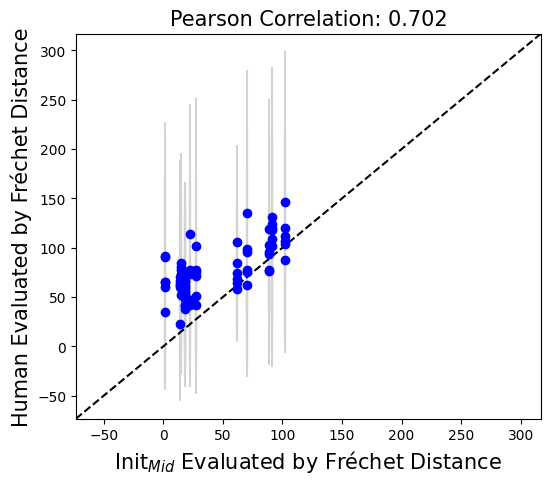

In [177]:
compareFD_model_human('runSimulation/simulated72_trial_data_Midline.json', df_all, 'Init$_{Mid}$')

In [132]:
def getBICFromPrediction(x_model, y_model, df_all, k):
    positions = np.sort(df_all['stimulus_idx'].unique())
    anchors = np.sort(df_all['obstacle_idx'].unique())

    # Aggregate data from all conditions, all anchors
    all_data = np.array([df_all[(df_all['stimulus_idx'] == pos) & (df_all['obstacle_idx'] == anc)][['triangle_final_x_flipback', 'triangle_final_y']].values for pos in positions for anc in anchors])
    print(len(all_data))

    # Mean models for all conditions
    all_mean_models = np.array([x_model, y_model]).T
    # print(all_mean_models)

    # Find a single best-fit covariance matrix for all conditions
    optimized_covariance, mle_all = find_single_best_covariance(all_data, all_mean_models, 'Powell')
    # optimized_covariance, mle_all = find_single_best_covariance(all_data, all_mean_models, None)

    print(f"Best sum log-likelihood: {np.sum(mle_all)}")
    print(f'Best covariance: {optimized_covariance}')
    print(f'BIC: {getBIC(k, 1440, np.sum(mle_all))}')
    return np.sum(mle_all)

# (2) Linear projection followed by refinement with a physics engine. 

The basic idea is that you initialize the triangle location at the linear projection hypothesis, then run a simulation to see where the ball goes. Depending on whether it's above or below the exit point, adjust the triangle up or down along the linear vertical path from the initial ball position. The parameters here would be the size of the increment and the stopping criterion (number of increments or some error threshold). It would be easier (as a start) to use a deterministic model (no noise, as in Kevin's model).

In [ ]:
# average response time per trial
df_all['response_time'].mean()

In [ ]:
exitPoints_two = allData.groupby('stimulus_idx')['projected_line_1'].first().values
exitPoints_single = [points[0] for points in exitPoints_two] # pick one point from the line
print(len(exitPoints_single))
x_projs = x_model
# print(x_projs)
y_projs = y_model
# print(y_projs)
ball_Xs = [322.3, 322.3, 322.3, 322.3, 500 , 500 , 500 , 500 , 604.4, 604.4, 604.4, 604.4]

In [ ]:
def getClosestPoint(point, point_list):
    x, y = point
    # Use min with a key function that calculates the absolute difference between x and x*.
    closest_point = min(point_list, key=lambda p: abs(p[0] - x))
    return closest_point

In [ ]:
x_gt_model = df_all.groupby(['stimulus_idx','obstacle_idx'])['obstacle_groundTruth_x'].first().values
y_gt_model = df_all.groupby(['stimulus_idx','obstacle_idx'])['obstacle_groundTruth_y'].first().values
print(x_gt_model[0],y_gt_model[0])

In [163]:
# Define constants for the simulation
d = 10  # Distance increment for adjusting obstacle position
epsilon = 10  # Tolerance for the desired proximity to the exit point
stimulus_idx = 6  # Identifier for the specific stimulus condition
obstacle_idx = 1  # Identifier for the specific obstacle configuration

# Initialize x and y positions for the obstacle across different stimulus and obstacle indices
x_init = [[intersections_modified_by_anchor[(stimulus_idx,obstacle_idx)][0] for obstacle_idx in anchors] for stimulus_idx in positions]
y_init = [[intersections_modified_by_anchor[(stimulus_idx,obstacle_idx)][1] for obstacle_idx in anchors] for stimulus_idx in positions]

# Function to find the solution by adjusting the obstacle position
def findSolution(stimulus_idx, obstacle_idx, d, epsilon, x_init, y_init, init='LP'):
    # Initial solution based on provided indices
    if init == 'LP':
        x_sol, y_sol = x_init[stimulus_idx-1][obstacle_idx-1], y_init[stimulus_idx-1][obstacle_idx-1]
    elif init == 'Anchor': 
        x_sol, y_sol = x_init[stimulus_idx-1][obstacle_idx-1], y_init[stimulus_idx][obstacle_idx]
    
    # Heuristic adjustment: if initial y position is outside the screen, bring it within the screen bounds
    if y_sol <= 150: y_sol = 150
    
    # Retrieve ball_X position for the given stimulus index
    ball_X = ball_Xs[stimulus_idx-1]

    # Filter dataset for the specific stimulus and obstacle index
    subset = df_all[(df_all['stimulus_idx'] == stimulus_idx) & (df_all['obstacle_idx'] == obstacle_idx)]
    exactPath = subset['exact_path_single'].iloc[0]  # Extract the first exact path for comparison
    
    directory = os.path.dirname(f'runSimulation/Model2_by72Trials/{stimulus_idx}-{obstacle_idx}/')
    if not os.path.exists(directory):
        os.makedirs(directory, exist_ok=True)
    
    # Define file path for simulation results
    file_path = f'runSimulation/Model2_by72Trials/{stimulus_idx}-{obstacle_idx}/simulation-results-{ball_X}-{int(x_sol)}-{int(y_sol)}.json'

    # Run simulation if results do not already exist
    if not os.path.exists(file_path):
        subprocess.run([
            "node", "runSimulation/Model2_by72Trials/simulateFunc.js",
            str(stimulus_idx), str(obstacle_idx), str(ball_X), str(x_sol), str(y_sol)
        ], check=True)
    
    # Load simulation results
    simulation_results = pd.read_json(file_path)
    simulatedPath = simulation_results['simulated_trial'].values
    
    # Calculate Frechet distances between simulated and exact paths for points out of screen
    l1_p, l2_p = pickPointsOutScreen(simulatedPath, top_y, bottom_y, left_x, right_x, ball_radius)
    l1_g, l2_g = pickPointsOutScreen(exactPath, top_y, bottom_y, left_x, right_x, ball_radius)
    if len(l2_p) != 0 and len(l1_p) != 0:
        fd1 = frechet_dist(l1_p, l1_g)
        fd2 = frechet_dist(l2_p, l2_g)
        print(fd2)

    # Calculate closest point on the simulated path to the predefined exit point
    exitPoint = exitPoints_single[stimulus_idx-1]
    x_exit, y_exit = exitPoint
    x_e, y_e = getClosestPoint(exitPoint, simulatedPath)

    # Initialize variables for while loop control
    n_steps = 0
    y_old = None
    y_two_iter_ago = None
    
    # Iteratively adjust y position of the obstacle to minimize the difference to the exit point
    while abs(y_e - y_exit) >= epsilon and n_steps < 5:
        # Break the loop if the y position hasn't changed over two iterations, indicating a potential deadlock
        if y_two_iter_ago is not None and y_sol == y_two_iter_ago:
            break
        
        # Update previous y positions for deadlock detection
        y_two_iter_ago = y_old
        y_old = y_sol
        
        # Adjust y position based on comparison with the exit y position
        if y_e < y_exit:
            y_sol += d
        else:
            y_sol -= d

        n_steps += 1  # Increment step counter
        
        # Run simulation with new y position and load results
        newFilePath = f'runSimulation/Model2_by72Trials/{stimulus_idx}-{obstacle_idx}/simulation-results-{ball_X}-{int(x_sol)}-{int(y_sol)}.json'
        if not os.path.exists(newFilePath):
            subprocess.run(["node", "runSimulation/Model2_by72Trials/simulateFunc.js",
                            str(stimulus_idx), str(obstacle_idx), str(ball_X), str(x_sol), str(y_sol)], check=True)
        simulation_results_new = pd.read_json(newFilePath)
        simulatedPath_new = simulation_results_new['simulated_trial'].values
        # Recalculate the closest point on the new simulated path to the predefined exit point
        x_e, y_e = getClosestPoint(exitPoint, simulatedPath_new)

        # Occasionally recalculate Frechet distances to monitor adjustment progress
        if n_steps % 5 == 0: 
            l1_p, l2_p = pickPointsOutScreen(simulatedPath_new, top_y, bottom_y, left_x, right_x, ball_radius)
            l1_g, l2_g = pickPointsOutScreen(exactPath, top_y, bottom_y, left_x, right_x, ball_radius)
            if len(l2_p) != 0 and len(l1_p) != 0:
                fd1 = frechet_dist(l1_p, l1_g)
                fd2 = frechet_dist(l2_p, l2_g)
                print(fd2)

        # Terminate if the adjusted position goes out of predefined screen bounds
        if y_sol <= 150 - 45 or y_sol >= 450 + 45:
            break

    # Return the final adjusted x and y positions of the obstacle, along with the number of steps taken
    return x_sol, y_sol, n_steps

# Example usage of the findSolution function
# Note: Ensure ball_Xs, exitPoints_single, top_y, bottom_y, left_x, right_x, ball_radius,
# and the functions getClosestPoint, pickPointsOutScreen, frechet_dist are defined

# findSolution(stimulus_idx, obstacle_idx, d, epsilon, x_init, y_init)

In [ ]:
def find_best_cov_model2(x_model, y_model, df_all):
    positions = np.sort(df_all['stimulus_idx'].unique())
    anchors = np.sort(df_all['obstacle_idx'].unique())
    
    # Aggregate data from all conditions
    all_data = np.array([df_all[(df_all['stimulus_idx'] == pos) & (df_all['obstacle_idx'] == anc)][['triangle_final_x_flipback', 'triangle_final_y']].values for pos in positions for anc in anchors])

    # Mean models for all conditions
    all_mean_models = np.array([x_model, y_model]).T

    # Find a single best-fit covariance matrix for all conditions
    optimized_covariance, mle_all = find_single_best_covariance(all_data, all_mean_models, 'Powell')
    
    return optimized_covariance, mle_all

## LP + Sim

In [156]:
# Model-Fitting Process
d_list = []
e_list = []
all_x_sols = []
all_y_sols = []
all_n_steps = []
cov_list = []
ml_list = []
best_n_step = 0
best_d = 0
best_e = 0
best_x = []
best_y = []
best_ml = -np.inf

# LP
x_init = [[intersections_modified_by_anchor[(stimulus_idx,obstacle_idx)][0] for obstacle_idx in anchors] for stimulus_idx in positions]
y_init = [[intersections_modified_by_anchor[(stimulus_idx,obstacle_idx)][1] for obstacle_idx in anchors] for stimulus_idx in positions]

# anchor
# y_init = df_all.groupby(['stimulus_idx','obstacle_idx'])['obstacle_initial_y'].first()

for d in [1, 5, 10, 20, 40]:
    for epsilon in [1, 5, 10, 20, 40]:
#         if d == 1 and epsilon == 1: pass
#         if d == 1 and epsilon == 5: pass
#         else:
            d_list.append(d)
            e_list.append(epsilon)
            x_sols, y_sols, n_steps = [], [], []
            for stimulus_idx in range(1, 13):
                for obstacle_idx in range(1, 7):
                    x_sol, y_sol, n_step = findSolution(stimulus_idx, obstacle_idx, d, epsilon, x_init, y_init)  # Assuming findSolution needs d and epsilon
                    x_sols.append(x_sol) # (1,1)(1,2)...(1,6)(2,1)...
                    y_sols.append(y_sol)
                    n_steps.append(n_step)
            all_x_sols.append(x_sols)
            all_y_sols.append(y_sols)
            all_n_steps.append(n_steps)
            new_cov, new_ml = find_best_cov_model2(x_sols, y_sols, df_all)  # Assuming this function is defined elsewhere
            cov_list.append(new_cov)
            ml_list.append(new_ml)
            if new_ml > best_ml:
                best_cov = new_cov
                best_ml = new_ml
                best_d, best_e = d, epsilon
                best_n_step = n_steps.copy()
                best_x, best_y = x_sols.copy(), y_sols.copy()  # Use copy to store the lists' current state
            
# After this process, best_d, best_e, best_x, and best_y will hold the best parameters and solutions found.

13.297370803285158
11.195960808707218
9.930491615110013
13.297370803285158
11.195960808707218
9.930491615110013
13.297370803285158
11.195960808707218
9.930491615110013
13.297370803285158
11.195960808707218
9.930491615110013
13.297370803285158
11.195960808707218
9.930491615110013
13.297370803285158
11.195960808707218
9.930491615110013
102.96829496535369
105.74576224665951
109.05186447180162
102.96829496535369
105.74576224665951
109.05186447180162
102.96829496535369
105.74576224665951
109.05186447180162
102.96829496535369
105.74576224665951
109.05186447180162
102.96829496535369
105.74576224665951
109.05186447180162
102.96829496535369
105.74576224665951
109.05186447180162
24.328150572297048
22.984022199560233
19.257774118627417
24.183304105385318
22.72551589410814
19.10629647055916
24.328150572297048
22.984022199560233
19.257774118627417
24.183304105385318
22.72551589410814
19.10629647055916
24.328150572297048
22.984022199560233
19.257774118627417
24.183304105385318
22.72551589410814
19.1

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 15843.659830638384
       x: [ 2.987e+01  0.000e+00  1.176e+02]
     nit: 2
   direc: [[ 1.000e+00  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00  0.000e+00]
           [-1.663e-02 -0.000e+00 -9.014e-02]]
    nfev: 73
13.297370803285158
11.195960808707218
9.930491615110013
13.297370803285158
11.195960808707218
9.930491615110013
13.297370803285158
11.195960808707218
9.930491615110013
13.297370803285158
11.195960808707218
9.930491615110013
13.297370803285158
11.195960808707218
9.930491615110013
13.297370803285158
11.195960808707218
9.930491615110013
102.96829496535369
105.74576224665951
109.05186447180162
102.96829496535369
105.74576224665951
109.05186447180162
102.96829496535369
105.74576224665951
109.05186447180162
102.96829496535369
105.74576224665951
109.05186447180162
102.96829496535369
105.74576224665951
109.05186447180162
102.96829496535369
105.74576224665951
109.05186447180162
24.328150

109.05186447180162
24.328150572297048
22.984022199560233
24.183304105385318
22.72551589410814
24.328150572297048
22.984022199560233
24.183304105385318
22.72551589410814
24.328150572297048
22.984022199560233
24.183304105385318
22.72551589410814
19.62623321618388
19.440227367060302
19.62623321618388
19.440227367060302
19.62623321618388
19.440227367060302
19.694463782246984
19.694463782246984
19.694463782246984
19.694463782246984
19.694463782246984
19.694463782246984
69.42294805696937
70.79372072239255
72.2136002042272
69.84365189806516
70.79372072239255
71.81611386355019
69.84365189806516
70.79372072239255
71.81611386355019
69.84365189806516
70.79372072239255
71.81611386355019
69.84365189806516
70.79372072239255
71.81611386355019
69.84365189806516
70.79372072239255
71.81611386355019
23.083406547503852
22.37155162005913
21.603403809439843
23.083406547503852
22.37155162005913
21.603403809439843
23.083406547503852
22.37155162005913
21.603403809439843
23.083406547503852
22.37155162005913
21.

14.10060070085884
14.438540260799911
85.1971220212384
90.56980776101388
97.82121239882485
85.1971220212384
90.56980776101388
97.82121239882485
85.1971220212384
90.56980776101388
97.82121239882485
84.88527103340425
90.56980776101388
97.0850534643795
85.1971220212384
90.56980776101388
97.82121239882485
85.1971220212384
90.56980776101388
97.82121239882485
6.265011459996499
22.57472186653854
6.265011459996499
22.57472186653854
6.265011459996499
22.57472186653854
6.265011459996499
22.57472186653854
6.265011459996499
22.57472186653854
6.265011459996499
21.54853690272993
39.9506736953113
21.54853690272993
39.9506736953113
21.54853690272993
39.9506736953113
21.54853690272993
39.9506736953113
21.54853690272993
39.9506736953113
21.54853690272993
39.9506736953113
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 16033.06161367498
       x: [ 2.988e+01  0.000e+00  1.342e+02]
     nit: 2
   direc: [[ 1.000e+00  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+

103.20149765251311
121.62460111658335
103.20149765251311
121.62460111658335
9.499490112591813
9.499490112591813
9.499490112591813
9.499490112591813
9.499490112591813
9.499490112591813
85.1971220212384
90.56980776101388
97.82121239882485
85.1971220212384
90.56980776101388
97.82121239882485
85.1971220212384
90.56980776101388
97.82121239882485
84.88527103340425
90.56980776101388
97.0850534643795
85.1971220212384
90.56980776101388
97.82121239882485
85.1971220212384
90.56980776101388
97.82121239882485
22.57472186653854
22.57472186653854
22.57472186653854
22.57472186653854
22.57472186653854
21.54853690272993
21.54853690272993
21.54853690272993
21.54853690272993
21.54853690272993
21.54853690272993
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 15990.133220400352
       x: [ 2.989e+01  0.000e+00  1.302e+02]
     nit: 2
   direc: [[ 1.000e+00  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00  0.000e+00]
           [ 1.860e-02  0.000e+00  1.123e-01]]


103.20149765251311
139.1388206202844
103.20149765251311
139.1388206202844
103.20149765251311
139.1388206202844
103.20149765251311
139.1388206202844
103.20149765251311
139.1388206202844
9.499490112591813
14.438540260799911
12.961076535661078
9.499490112591813
14.438540260799911
12.961076535661078
9.499490112591813
14.438540260799911
12.961076535661078
9.499490112591813
14.438540260799911
12.961076535661078
9.499490112591813
14.438540260799911
12.961076535661078
9.499490112591813
14.438540260799911
12.961076535661078
85.1971220212384
97.82121239882485
135.4467330703871
85.1971220212384
97.82121239882485
135.4467330703871
85.1971220212384
97.82121239882485
135.4467330703871
84.88527103340425
97.0850534643795
135.08397823794908
85.1971220212384
97.82121239882485
135.4467330703871
85.1971220212384
97.82121239882485
135.4467330703871
22.57472186653854
22.57472186653854
22.57472186653854
22.57472186653854
22.57472186653854
21.54853690272993
21.54853690272993
21.54853690272993
21.5485369027299

19.440227367060302
19.62623321618388
19.440227367060302
19.62623321618388
19.440227367060302
19.694463782246984
19.694463782246984
19.694463782246984
19.694463782246984
19.694463782246984
19.694463782246984
69.42294805696937
127.73525145553612
69.84365189806516
127.73525145553612
69.84365189806516
127.73525145553612
69.84365189806516
127.73525145553612
69.84365189806516
127.73525145553612
69.84365189806516
127.73525145553612
23.083406547503852
5.211399856845446
23.083406547503852
5.121435742699586
23.083406547503852
5.211399856845446
23.083406547503852
5.121435742699586
23.083406547503852
5.211399856845446
23.083406547503852
5.121435742699586
103.20149765251311
103.20149765251311
103.20149765251311
103.20149765251311
103.20149765251311
103.20149765251311
9.499490112591813
12.961076535661078
9.499490112591813
12.961076535661078
9.499490112591813
12.961076535661078
9.499490112591813
12.961076535661078
9.499490112591813
12.961076535661078
9.499490112591813
12.961076535661078
85.1971220212

103.20149765251311
103.20149765251311
103.20149765251311
103.20149765251311
103.20149765251311
9.499490112591813
12.122574236388056
9.499490112591813
12.122574236388056
9.499490112591813
12.122574236388056
9.499490112591813
12.122574236388056
9.499490112591813
12.122574236388056
9.499490112591813
12.122574236388056
85.1971220212384
85.1971220212384
85.1971220212384
84.88527103340425
85.1971220212384
85.1971220212384
22.57472186653854
22.57472186653854
22.57472186653854
22.57472186653854
22.57472186653854
21.54853690272993
21.54853690272993
21.54853690272993
21.54853690272993
21.54853690272993
21.54853690272993
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 16294.250686786261
       x: [ 2.987e+01  0.000e+00  1.609e+02]
     nit: 2
   direc: [[ 1.000e+00  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00  0.000e+00]
           [-1.333e-02 -0.000e+00 -1.013e-01]]
    nfev: 68
13.297370803285158
13.297370803285158
13.297370803285158
13.297370803

In [160]:
print('best_cov')
print(best_cov)
print('best_ml')
print(best_ml)
print('best_d, best_e')
print(best_d, best_e)

best_cov
[[  893.20068823     0.        ]
 [    0.         13582.25819839]]
best_ml
-15830.593004158285
best_d, best_e
1 10


In [161]:
getBICFromPrediction(best_x, best_y, df_all, 4)

72
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 15830.593004158285
       x: [ 2.989e+01  0.000e+00  1.165e+02]
     nit: 2
   direc: [[ 1.000e+00  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00  0.000e+00]
           [ 2.156e-02  0.000e+00  1.153e-01]]
    nfev: 67
Best sum log-likelihood: -15830.593004158285
Best covariance: [[  893.20068823     0.        ]
 [    0.         13582.25819839]]
BIC: 31690.27560188685


-15830.593004158285

In [159]:
modelName = 'LP+Sim_max10'
with open(f'runSimulation/x_coords_{modelName}.pkl', 'wb') as f:
    pickle.dump(best_x, f)
with open(f'runSimulation/y_coords_{modelName}.pkl', 'wb') as f:
    pickle.dump(best_y, f)

Pearson Correlation: 0.6306847233826285


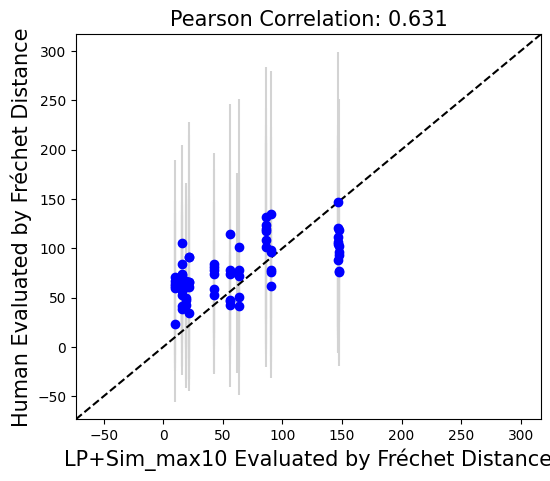

In [162]:
jsonFilePath = 'runSimulation/simulated72_trial_data_LP+Sim_max10.json'
compareFD_model_human(jsonFilePath, df_all, 'LP+Sim_max10')

## Anchor + Sim

In [164]:
# Model-Fitting Process
d_list = []
e_list = []
all_x_sols = []
all_y_sols = []
all_n_steps = []
cov_list = []
ml_list = []
best_n_step = 0
best_d = 0
best_e = 0
best_x = []
best_y = []
best_ml = -np.inf

# LP
x_init = [[intersections_modified_by_anchor[(stimulus_idx,obstacle_idx)][0] for obstacle_idx in anchors] for stimulus_idx in positions]
y_init = df_all.groupby(['stimulus_idx','obstacle_idx'])['obstacle_initial_y'].first()

for d in [1, 5, 10, 20, 40]:
    for epsilon in [1, 5, 10, 20, 40]:
#         if d == 1 and epsilon == 1: pass
#         if d == 1 and epsilon == 5: pass
#         else:
            d_list.append(d)
            e_list.append(epsilon)
            x_sols, y_sols, n_steps = [], [], []
            for stimulus_idx in range(1, 13):
                for obstacle_idx in range(1, 7):
                    x_sol, y_sol, n_step = findSolution(stimulus_idx, obstacle_idx, d, epsilon, x_init, y_init, 'Anchor')  # Assuming findSolution needs d and epsilon
                    x_sols.append(x_sol) # (1,1)(1,2)...(1,6)(2,1)...
                    y_sols.append(y_sol)
                    n_steps.append(n_step)
            all_x_sols.append(x_sols)
            all_y_sols.append(y_sols)
            all_n_steps.append(n_steps)
            new_cov, new_ml = find_best_cov_model2(x_sols, y_sols, df_all)  # Assuming this function is defined elsewhere
            cov_list.append(new_cov)
            ml_list.append(new_ml)
            if new_ml > best_ml:
                best_cov = new_cov
                best_ml = new_ml
                best_d, best_e = d, epsilon
                best_n_step = n_steps.copy()
                best_x, best_y = x_sols.copy(), y_sols.copy()  # Use copy to store the lists' current state
            
# After this process, best_d, best_e, best_x, and best_y will hold the best parameters and solutions found.

5.763938132809239
3.3565553684943152
39.82272590133302
37.68842020845793
5.763938132809239
3.3565553684943152
39.82272590133302
37.68842020845793
5.763938132809239
3.3565553684943152
39.82272590133302
37.68842020845793
82.33220590074858
81.9310190571312
127.74160515242406
125.60723483265586
82.33220590074858
81.9310190571312
127.74160515242406
125.60723483265586
82.33220590074858
81.9310190571312
127.74160515242406
125.60723483265586
38.03129350238986
35.39597747914607
7.3934358768423145
5.451483487870439
38.03129350238986
35.39597747914607
7.3934358768423145
5.451483487870439
38.03129350238986
35.39597747914607
7.3934358768423145
5.451483487870439
38.37517821165494
35.7567245546343
7.0550919497125255
5.180551358553351
38.37517821165494
35.7567245546343
7.0550919497125255
5.180551358553351
38.37517821165494
35.7567245546343
7.0550919497125255
5.180551358553351
7.9174946903320516
7.014600781725567
53.34103345215259
51.24027954292052
7.9174946903320516
7.014600781725567
53.34103345215259

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 15065.31908493467
       x: [ 2.988e+01  0.000e+00  6.851e+01]
     nit: 2
   direc: [[ 1.000e+00  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00  0.000e+00]
           [ 7.062e-03  0.000e+00  2.077e-02]]
    nfev: 74
5.763938132809239
39.82272590133302
37.68842020845793
5.763938132809239
39.82272590133302
37.68842020845793
5.763938132809239
39.82272590133302
37.68842020845793
82.33220590074858
81.9310190571312
127.74160515242406
125.60723483265586
82.33220590074858
81.9310190571312
127.74160515242406
125.60723483265586
82.33220590074858
81.9310190571312
127.74160515242406
125.60723483265586
38.03129350238986
35.39597747914607
7.3934358768423145
38.03129350238986
35.39597747914607
7.3934358768423145
38.03129350238986
35.39597747914607
7.3934358768423145
38.37517821165494
35.7567245546343
7.0550919497125255
38.37517821165494
35.7567245546343
7.0550919497125255
38.37517821165494
35.7567245546343

29.706374142627936
7.3934358768423145
38.03129350238986
29.706374142627936
7.3934358768423145
38.03129350238986
29.706374142627936
7.3934358768423145
38.37517821165494
30.047579360414844
7.0550919497125255
38.37517821165494
30.047579360414844
7.0550919497125255
38.37517821165494
30.047579360414844
7.0550919497125255
7.9174946903320516
53.34103345215259
39.00407015418142
7.9174946903320516
53.34103345215259
39.00407015418142
7.9174946903320516
53.34103345215259
39.00407015418142
63.41890949055569
63.826813163705005
83.39277336830926
75.43624116590746
63.41890949055569
63.826813163705005
83.39277336830926
75.43624116590746
63.41890949055569
63.826813163705005
83.39277336830926
75.43624116590746
18.853656687126062
10.777671965887702
26.881352467941458
12.77432590337382
18.853656687126062
10.777671965887702
26.881352467941458
12.77432590337382
18.853656687126062
10.777671965887702
26.881352467941458
12.77432590337382
81.9619512998606
82.37133765573904
112.0250083644444
97.71995493634763
81

39.00407015418142
63.41890949055569
63.826813163705005
83.39277336830926
75.43624116590746
63.41890949055569
63.826813163705005
83.39277336830926
75.43624116590746
63.41890949055569
63.826813163705005
83.39277336830926
75.43624116590746
18.853656687126062
26.881352467941458
18.853656687126062
26.881352467941458
18.853656687126062
26.881352467941458
81.9619512998606
82.37133765573904
112.0250083644444
97.71995493634763
81.9619512998606
82.37133765573904
112.0250083644444
97.71995493634763
81.9619512998606
82.37133765573904
112.0250083644444
97.71995493634763
12.961076535661078
40.460429790319196
26.133605627758342
12.961076535661078
40.460429790319196
26.133605627758342
12.961076535661078
40.460429790319196
26.133605627758342
84.53840808253187
84.94468785987834
104.50945757872294
96.54454906662944
84.53840808253187
84.94468785987834
104.50945757872294
96.54454906662944
84.53840808253187
84.94468785987834
104.50945757872294
96.54454906662944
82.13000569495033
73.80420717952389
36.7054721

104.50945757872294
91.54291830799805
82.13000569495033
62.2317639300308
36.705472192546615
4.958853107877954
82.13000569495033
62.2317639300308
36.705472192546615
4.958853107877954
82.13000569495033
62.2317639300308
36.705472192546615
4.958853107877954
2.975296045377303
47.977267255134976
22.453345045150613
2.975296045377303
47.977267255134976
22.453345045150613
2.975296045377303
47.977267255134976
22.453345045150613
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 14974.557440536968
       x: [ 2.988e+01  0.000e+00  6.433e+01]
     nit: 2
   direc: [[ 1.000e+00  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00  0.000e+00]
           [-7.217e-03 -0.000e+00 -1.973e-02]]
    nfev: 66
5.763938132809239
39.82272590133302
14.313941768951903
5.763938132809239
39.82272590133302
14.313941768951903
5.763938132809239
39.82272590133302
14.313941768951903
82.33220590074858
83.951029714232
127.74160515242406
102.21752683671627
82.33220590074858
83.95102971

38.03129350238986
7.3934358768423145
7.3934358768423145
38.37517821165494
7.0550919497125255
7.0550919497125255
38.37517821165494
7.0550919497125255
7.0550919497125255
38.37517821165494
7.0550919497125255
7.0550919497125255
7.9174946903320516
53.34103345215259
7.9174946903320516
7.9174946903320516
53.34103345215259
7.9174946903320516
7.9174946903320516
53.34103345215259
7.9174946903320516
63.41890949055569
84.65417000814253
83.39277336830926
63.41890949055569
63.41890949055569
84.65417000814253
83.39277336830926
63.41890949055569
63.41890949055569
84.65417000814253
83.39277336830926
63.41890949055569
18.853656687126062
26.881352467941458
18.853656687126062
26.881352467941458
18.853656687126062
26.881352467941458
81.9619512998606
103.20149765251311
112.0250083644444
81.9619512998606
81.9619512998606
103.20149765251311
112.0250083644444
81.9619512998606
81.9619512998606
103.20149765251311
112.0250083644444
81.9619512998606
12.961076535661078
40.460429790319196
12.961076535661078
40.46042

7.3934358768423145
38.03129350238986
7.3934358768423145
38.37517821165494
7.0550919497125255
38.37517821165494
7.0550919497125255
38.37517821165494
7.0550919497125255
7.9174946903320516
53.34103345215259
4.582771443107446
7.9174946903320516
53.34103345215259
4.582771443107446
7.9174946903320516
53.34103345215259
4.582771443107446
63.41890949055569
83.39277336830926
84.65417000814253
63.41890949055569
83.39277336830926
84.65417000814253
63.41890949055569
83.39277336830926
84.65417000814253
18.853656687126062
26.881352467941458
18.853656687126062
26.881352467941458
18.853656687126062
26.881352467941458
81.9619512998606
112.0250083644444
103.20149765251311
81.9619512998606
112.0250083644444
103.20149765251311
81.9619512998606
112.0250083644444
103.20149765251311
12.961076535661078
40.460429790319196
12.961076535661078
40.460429790319196
12.961076535661078
40.460429790319196
84.53840808253187
104.50945757872294
105.76625536995935
84.53840808253187
104.50945757872294
105.76625536995935
84.5

105.76625536995935
84.53840808253187
104.50945757872294
105.76625536995935
82.13000569495033
36.705472192546615
82.13000569495033
36.705472192546615
82.13000569495033
36.705472192546615
2.975296045377303
47.977267255134976
2.975296045377303
47.977267255134976
2.975296045377303
47.977267255134976
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 15782.160535310131
       x: [ 2.988e+01  0.000e+00  1.127e+02]
     nit: 2
   direc: [[ 1.000e+00  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00  0.000e+00]
           [-1.939e-03 -0.000e+00 -1.002e-02]]
    nfev: 68


In [165]:
print('best_cov')
print(best_cov)
print('best_ml')
print(best_ml)
print('best_d, best_e')
print(best_d, best_e)

best_cov
[[ 892.72684714    0.        ]
 [   0.         4056.75314468]]
best_ml
-14960.28103773262
best_d, best_e
5 5


In [166]:
getBICFromPrediction(best_x, best_y, df_all, 4)

72
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 14960.28103773262
       x: [ 2.988e+01  0.000e+00  6.369e+01]
     nit: 2
   direc: [[ 1.000e+00  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00  0.000e+00]
           [-2.021e-03 -0.000e+00 -5.459e-03]]
    nfev: 70
Best sum log-likelihood: -14960.28103773262
Best covariance: [[ 892.72684714    0.        ]
 [   0.         4056.75314468]]
BIC: 29949.65166903552


-14960.28103773262

In [167]:
modelName = 'Anchor+Sim_max5'
with open(f'runSimulation/x_coords_{modelName}.pkl', 'wb') as f:
    pickle.dump(best_x, f)
with open(f'runSimulation/y_coords_{modelName}.pkl', 'wb') as f:
    pickle.dump(best_y, f)

Pearson Correlation: 0.698303272068628


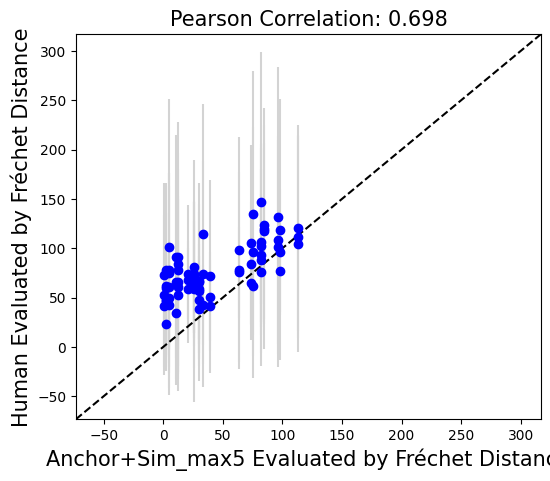

In [170]:
jsonFilePath = 'runSimulation/simulated72_trial_data_Anchor+Sim_max5.json'
compareFD_model_human(jsonFilePath, df_all, 'Anchor+Sim_max5')

## Midline+Sim

In [171]:
# Model-Fitting Process
d_list = []
e_list = []
all_x_sols = []
all_y_sols = []
all_n_steps = []
cov_list = []
ml_list = []
best_n_step = 0
best_d = 0
best_e = 0
best_x = []
best_y = []
best_ml = -np.inf

# LP
x_init = [[intersections_modified_by_anchor[(stimulus_idx,obstacle_idx)][0] for obstacle_idx in anchors] for stimulus_idx in positions]
y_init = [[300]*6]*12

for d in [1, 5, 10, 20, 40]:
    for epsilon in [1, 5, 10, 20, 40]:
#         if d == 1 and epsilon == 1: pass
#         if d == 1 and epsilon == 5: pass
#         else:
            d_list.append(d)
            e_list.append(epsilon)
            x_sols, y_sols, n_steps = [], [], []
            for stimulus_idx in range(1, 13):
                for obstacle_idx in range(1, 7):
                    x_sol, y_sol, n_step = findSolution(stimulus_idx, obstacle_idx, d, epsilon, x_init, y_init)  # Assuming findSolution needs d and epsilon
                    x_sols.append(x_sol) # (1,1)(1,2)...(1,6)(2,1)...
                    y_sols.append(y_sol)
                    n_steps.append(n_step)
            all_x_sols.append(x_sols)
            all_y_sols.append(y_sols)
            all_n_steps.append(n_steps)
            new_cov, new_ml = find_best_cov_model2(x_sols, y_sols, df_all)  # Assuming this function is defined elsewhere
            cov_list.append(new_cov)
            ml_list.append(new_ml)
            if new_ml > best_ml:
                best_cov = new_cov
                best_ml = new_ml
                best_d, best_e = d, epsilon
                best_n_step = n_steps.copy()
                best_x, best_y = x_sols.copy(), y_sols.copy()  # Use copy to store the lists' current state
            
# After this process, best_d, best_e, best_x, and best_y will hold the best parameters and solutions found.

14.313941768951903
10.54690208757224
14.313941768951903
10.54690208757224
14.313941768951903
10.54690208757224
14.313941768951903
10.54690208757224
14.313941768951903
10.54690208757224
14.313941768951903
10.54690208757224
102.21752683671627
98.36584620855965
102.21752683671627
98.36584620855965
102.21752683671627
98.36584620855965
102.21752683671627
98.36584620855965
102.21752683671627
98.36584620855965
102.21752683671627
98.36584620855965
18.20480477155593
16.661890264936584
18.0552073648991
16.554043819001734
18.20480477155593
16.661890264936584
18.0552073648991
16.554043819001734
18.20480477155593
16.661890264936584
18.0552073648991
16.554043819001734
18.568881805519034
17.01786331860593
18.385051816960065
16.8851378623389
18.568881805519034
17.01786331860593
18.385051816960065
16.8851378623389
18.568881805519034
17.01786331860593
18.385051816960065
16.8851378623389
27.893119385857506
23.950923479057593
27.893119385857506
23.950923479057593
27.893119385857506
23.950923479057593
27.8

18.664274993772658
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 14603.355749059765
       x: [ 2.988e+01  0.000e+00  4.971e+01]
     nit: 2
   direc: [[ 1.000e+00  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00  0.000e+00]
           [ 2.360e-03  0.000e+00  4.712e-03]]
    nfev: 70
14.313941768951903
10.54690208757224
14.313941768951903
10.54690208757224
14.313941768951903
10.54690208757224
14.313941768951903
10.54690208757224
14.313941768951903
10.54690208757224
14.313941768951903
10.54690208757224
102.21752683671627
98.36584620855965
102.21752683671627
98.36584620855965
102.21752683671627
98.36584620855965
102.21752683671627
98.36584620855965
102.21752683671627
98.36584620855965
102.21752683671627
98.36584620855965
18.20480477155593
16.661890264936584
18.0552073648991
16.554043819001734
18.20480477155593
16.661890264936584
18.0552073648991
16.554043819001734
18.20480477155593
16.661890264936584
18.0552073648991
16.554043819001734
18.56

18.20480477155593
6.955966327919419
18.0552073648991
6.819787742859834
18.20480477155593
6.955966327919419
18.0552073648991
6.819787742859834
18.20480477155593
6.955966327919419
18.0552073648991
6.819787742859834
18.568881805519034
7.291487196324166
18.385051816960065
7.121369325819942
18.568881805519034
7.291487196324166
18.385051816960065
7.121369325819942
18.568881805519034
7.291487196324166
18.385051816960065
7.121369325819942
27.893119385857506
16.25253183566686
27.893119385857506
16.25253183566686
27.893119385857506
16.25253183566686
27.893119385857506
16.25253183566686
27.893119385857506
16.25253183566686
27.893119385857506
16.25253183566686
70.41801440763071
65.41716688727736
70.41801440763071
65.41716688727736
70.41801440763071
65.41716688727736
70.41801440763071
65.41716688727736
70.41801440763071
65.41716688727736
70.41801440763071
65.41716688727736
1.4754717346594182
1.4754717346594182
1.4754717346594182
1.4754717346594182
1.4754717346594182
1.4754717346594182
88.9471204737

88.94712047372005
83.96580930662131
88.94712047372005
83.96580930662131
88.94712047372005
83.96580930662131
88.94712047372005
83.96580930662131
88.94712047372005
83.96580930662131
88.94712047372005
83.96580930662131
15.011714183406797
15.011714183406797
15.011714183406797
15.011714183406797
15.011714183406797
15.011714183406797
91.54291830799805
86.52633988855753
91.54291830799805
86.52633988855753
91.54291830799805
86.52633988855753
91.54291830799805
86.52633988855753
91.54291830799805
86.52633988855753
91.54291830799805
86.52633988855753
62.2317639300308
51.04767214259925
62.2317639300308
51.04767214259925
62.2317639300308
51.04767214259925
62.2317639300308
51.04767214259925
62.2317639300308
51.04767214259925
62.2317639300308
51.04767214259925
22.453345045150613
22.453345045150613
22.453345045150613
22.453345045150613
22.453345045150613
22.453345045150613
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 14592.914968449357
       x: [ 2.988e+01  0.0

2.975296045377303
22.453345045150613
2.975296045377303
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 14796.244088516412
       x: [ 2.988e+01  0.000e+00  5.684e+01]
     nit: 2
   direc: [[ 1.000e+00  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00  0.000e+00]
           [-3.658e-03 -0.000e+00 -8.618e-03]]
    nfev: 69
14.313941768951903
14.313941768951903
14.313941768951903
14.313941768951903
14.313941768951903
14.313941768951903
102.21752683671627
82.33220590074858
102.21752683671627
82.33220590074858
102.21752683671627
82.33220590074858
102.21752683671627
82.33220590074858
102.21752683671627
82.33220590074858
102.21752683671627
82.33220590074858
18.20480477155593
18.0552073648991
18.20480477155593
18.0552073648991
18.20480477155593
18.0552073648991
18.568881805519034
18.385051816960065
18.568881805519034
18.385051816960065
18.568881805519034
18.385051816960065
27.893119385857506
27.893119385857506
27.893119385857506
27.893119385857506
2

4.958853107877954
62.2317639300308
4.958853107877954
62.2317639300308
4.958853107877954
62.2317639300308
4.958853107877954
62.2317639300308
4.958853107877954
22.453345045150613
22.453345045150613
22.453345045150613
22.453345045150613
22.453345045150613
22.453345045150613
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 15240.823773721739
       x: [ 2.988e+01  0.000e+00  7.740e+01]
     nit: 2
   direc: [[ 1.000e+00  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00  0.000e+00]
           [-9.158e-03 -0.000e+00 -3.106e-02]]
    nfev: 67
14.313941768951903
14.313941768951903
14.313941768951903
14.313941768951903
14.313941768951903
14.313941768951903
102.21752683671627
83.951029714232
102.21752683671627
83.951029714232
102.21752683671627
83.951029714232
102.21752683671627
83.951029714232
102.21752683671627
83.951029714232
102.21752683671627
83.951029714232
18.20480477155593
18.0552073648991
18.20480477155593
18.0552073648991
18.20480477155593
18.

62.2317639300308
62.2317639300308
62.2317639300308
62.2317639300308
62.2317639300308
22.453345045150613
22.453345045150613
22.453345045150613
22.453345045150613
22.453345045150613
22.453345045150613
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 15867.827791948544
       x: [ 2.988e+01  0.000e+00  1.196e+02]
     nit: 2
   direc: [[ 1.000e+00  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00  0.000e+00]
           [-5.040e-03 -0.000e+00 -2.780e-02]]
    nfev: 68
14.313941768951903
14.313941768951903
14.313941768951903
14.313941768951903
14.313941768951903
14.313941768951903
102.21752683671627
138.9069140399397
102.21752683671627
138.9069140399397
102.21752683671627
138.9069140399397
102.21752683671627
138.9069140399397
102.21752683671627
138.9069140399397
102.21752683671627
138.9069140399397
18.20480477155593
18.0552073648991
18.20480477155593
18.0552073648991
18.20480477155593
18.0552073648991
18.568881805519034
18.385051816960065
18.568881

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 15840.146293589938
       x: [ 2.987e+01  0.000e+00  1.174e+02]
     nit: 2
   direc: [[ 1.000e+00  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00  0.000e+00]
           [-1.888e-02 -0.000e+00 -1.021e-01]]
    nfev: 65


In [172]:
print('best_cov')
print(best_cov)
print('best_ml')
print(best_ml)
print('best_d, best_e')
print(best_d, best_e)

best_cov
[[ 892.89309421    0.        ]
 [   0.         2435.11969473]]
best_ml
-14592.914968449357
best_d, best_e
5 40


In [173]:
getBICFromPrediction(best_x, best_y, df_all, 4)

72
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 14592.914968449357
       x: [ 2.988e+01  0.000e+00  4.935e+01]
     nit: 2
   direc: [[ 1.000e+00  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00  0.000e+00]
           [ 4.766e-03  0.000e+00  9.428e-03]]
    nfev: 70
Best sum log-likelihood: -14592.914968449357
Best covariance: [[ 892.89309421    0.        ]
 [   0.         2435.11969473]]
BIC: 29214.919530468993


-14592.914968449357

In [174]:
modelName = 'Mid+Sim_max5'
with open(f'runSimulation/x_coords_{modelName}.pkl', 'wb') as f:
    pickle.dump(best_x, f)
with open(f'runSimulation/y_coords_{modelName}.pkl', 'wb') as f:
    pickle.dump(best_y, f)

Pearson Correlation: 0.7052814710986333


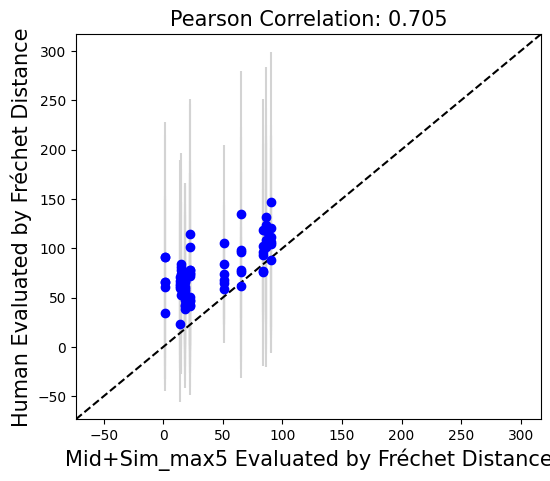

In [175]:
jsonFilePath = 'runSimulation/simulated72_trial_data_Mid+Sim_max5.json'
compareFD_model_human(jsonFilePath, df_all, 'Mid+Sim_max5')

In [ ]:
# d_list = []
# e_list = []
# all_x_sols = []
# all_y_sols = []
# all_n_steps = []
# cov_list = []
# ml_list = []
# best_n_step = 0
# best_d = 0
# best_e = 0
# best_x = []
# best_y = []
# best_ml = -np.inf

In [ ]:
# for d in [1, 2, 5, 10, 15, 20, 30, 40]:
#     for epsilon in [1, 2, 5, 10, 15, 20, 30, 40]:
# #         if d == 1 and epsilon == 1: pass
# #         if d == 1 and epsilon == 5: pass
# #         else:
#         d_list.append(d)
#         e_list.append(epsilon)
#         x_sols, y_sols, n_steps = [], [], []
#         for stimulus_idx in range(1, 13):
#             x_sol, y_sol, n_step = findSolution(stimulus_idx, d, epsilon)  # Assuming findSolution needs d and epsilon
#             x_sols.append(x_sol)
#             y_sols.append(y_sol)
#             n_steps.append(n_step)
#         all_x_sols.append(x_sols)
#         all_y_sols.append(y_sols)
#         all_n_steps.append(n_steps)
#         new_cov, new_ml = find_best_cov_model2(x_sols, y_sols, df_all)  # Assuming this function is defined elsewhere
#         cov_list.append(new_cov)
#         ml_list.append(new_ml)
#         if new_ml > best_ml:
#             best_cov = new_cov
#             best_ml = new_ml
#             best_d, best_e = d, epsilon
#             best_n_step = n_steps.copy()
#             best_x, best_y = x_sols.copy(), y_sols.copy()  # Use copy to store the lists' current state
            
# # After this process, best_d, best_e, best_x, and best_y will hold the best parameters and solutions found.

In [ ]:
# from scipy.stats import multivariate_normal

# # x_model = [intersections[key+1][0] for key in range(12)]
# # y_model = [intersections[key+1][1] for key in range(12)]

# x_model = best_x
# y_model = best_y

# # print(x_model)
# # print(y_model)

# # Creating 4x3 grid of subplots
# fig, axes = plt.subplots(4, 3, figsize=(16, 14), constrained_layout=True)

# positions = np.sort(df_all['stimulus_idx'].unique())
# # positions = positions.reshape((3, 4)).T.flatten()
# print(positions)
# # Aggregate data from all conditions

# all_data = np.array([df_all[df_all['stimulus_idx'] == pos][['triangle_final_x_flipback', 'triangle_final_y']].values for pos in positions])
# print(len(all_data))

# # Mean models for all conditions
# all_mean_models = np.array([x_model, y_model]).T
# print(all_mean_models)

# # Find a single best-fit covariance matrix for all conditions
# optimized_covariance, mle_all = find_single_best_covariance(all_data, all_mean_models, 'Powell')

# mle_all = []

# positions = positions.reshape((3, 4)).T.flatten()
# for index, position in enumerate(positions):
#     ax = axes.flatten()[index]
#     subset = df_all[df_all['stimulus_idx'] == position]
#     mean_model = [x_model[int(position-1)], y_model[int(position-1)]]
#     xy_positions = np.column_stack((subset['triangle_final_x_flipback'], subset['triangle_final_y']))

#     # Use the same optimized covariance matrix for each condition
#     mean_human = np.mean(xy_positions, axis=0)
#     rv_model = multivariate_normal(mean_model, optimized_covariance)
#     rv_human = multivariate_normal(mean_human, np.cov(xy_positions.T))

#     likelihood = calculate_likelihood(xy_positions, mean_model, optimized_covariance)
#     mle_all.append(likelihood)

#     # Create a grid of x and y values
#     x = np.linspace(100, 900, 1000)
#     y = np.linspace(-100, 600, 1000)
#     X, Y = np.meshgrid(x, y)
#     pos = np.dstack((X, Y))

#     # Calculate the density values
#     density_model = rv_model.pdf(pos)
#     density_human = rv_human.pdf(pos)

#     # Calculate difference in densities
#     density_diff = density_human - density_model

#     # Plotting in the current subplot
# #     cax = ax.imshow(density_diff, extent=[0, 100, 0, 100], origin='lower', cmap='RdBu', clim=(-0.001, 0.001))
#     cax = ax.imshow(density_diff, extent=[100, 900, -100, 600], origin='lower', cmap='RdBu', clim=(-0.00015, 0.00015))
#     ax.scatter(*mean_model, color='red', label='Model Mean')
#     ax.scatter(*mean_human, color='blue', label='Human Mean')
#     ax.set_title(f'Stimulus {int(position)}')
#     ax.set_xlabel('X Coordinate')
#     ax.set_ylabel('Y Coordinate')
#     ax.invert_yaxis()

# print(f"Best sum log-likelihood: {-np.sum(mle_all)}")
# print(f'Best covariance: {optimized_covariance}')
# print(f'BIC: {getBIC(5, 1440, -np.sum(mle_all))}')

# # Capture handles for legend (using the last subplot for convenience)
# handles, labels = axes[-1, -1].get_legend_handles_labels()
    
# # Adding a unified legend to the figure
# fig.legend(handles, labels, loc='upper right')

# # Adding a colorbar
# fig.colorbar(cax, ax=axes.ravel().tolist(), shrink=0.8, aspect=25, label='Difference in Density')

# plt.savefig('Linear Projection + Simulation with MLE vs. Human Data.pdf')
# plt.show()

## Max # of Adjustment